## Problem Statement

The objective of this project is to use deep learning techniques to predict the (x, y) coordinates of a single bright pixel in a 50×50 grayscale image.

Each image contains exactly one pixel with intensity value 255, while all other pixels have value 0. The task is formulated as a regression problem where the model learns to predict the spatial location of the bright pixel.

A synthetic dataset is generated programmatically to simulate this scenario, and a Convolutional Neural Network (CNN) is used to perform coordinate prediction.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)



In [77]:
def generate_dataset(num_samples, image_size=50):
    """
    Generates synthetic dataset of grayscale images.

    Each image contains exactly one bright pixel (value = 255)
    at a random (x, y) coordinate. The task is to predict
    this coordinate using deep learning.

    Args:
        num_samples (int): Number of images to generate.
        image_size (int): Height and width of square image.

    Returns:
        images (numpy array): Shape (num_samples, image_size, image_size, 1)
        labels (numpy array): Shape (num_samples, 2)
    """
    images = []
    labels = []

    for _ in range(num_samples):
        image = np.zeros((image_size, image_size), dtype=np.float32)
        
        x = np.random.randint(0, image_size)
        y = np.random.randint(0, image_size)
        
        image[x, y] = 255.0
        
        images.append(image)
        labels.append([x, y])

    images = np.array(images)
    labels = np.array(labels)

    # Normalize pixel values to range [0, 1] for stable training
    images = images / 255.0

    # Add channel dimension for CNN compatibility
    images = images.reshape(-1, image_size, image_size, 1)

    return images, labels


# Generate dataset
X, y = generate_dataset(7000)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 4900
Validation samples: 1050
Test samples: 1050


## Dataset Rationale

Each 50×50 image was generated with all pixel values set to 0.
A single pixel was randomly selected and assigned the value 255.

The pixel position was chosen using uniform random sampling
so that all locations in the image are equally represented.

A total of 7000 samples were generated and split into
training, validation, and test sets.

Images were normalized to improve training stability.


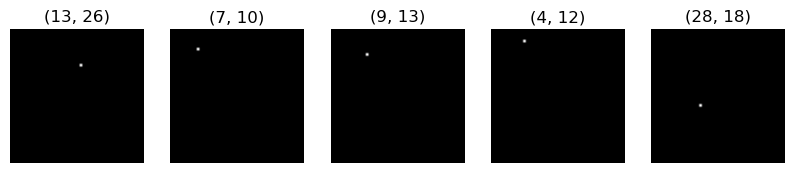

In [80]:
def visualize_samples(images, labels, num_samples=5):
    plt.figure(figsize=(10, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"({labels[i][0]}, {labels[i][1]})")
        plt.axis('off')
    plt.show()


visualize_samples(X_train, y_train)


In [82]:
def build_model(input_shape=(50, 50, 1)):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2)  # Output layer for (x, y)
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model


model = build_model()
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 22, 22, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3872)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         247,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,802 (987.51 KB)

 Trainable params: 252,802 (987.51 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 238.8887 - mae: 12.3327 - val_loss: 76.1393 - val_mae: 6.3218
Epoch 2/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 36.4847 - mae: 3.8643 - val_loss: 26.9611 - val_mae: 3.2747
Epoch 3/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 19.4043 - mae: 2.8350 - val_loss: 18.0273 - val_mae: 2.7617
Epoch 4/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 13.4274 - mae: 2.4544 - val_loss: 12.8596 - val_mae: 2.3637
Epoch 5/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 10.2132 - mae: 2.1718 - val_loss: 10.5679 - val_mae: 2.1926
Epoch 6/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 8.2300 - mae: 1.9421 - val_loss: 9.1329 - val_mae: 2.0669
Epoch 7/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.7303 - mae: 1.7434 - val_loss: 7.7378 - val_mae: 1.8977
Epoch 8/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 5.5213 - mae: 1.5688 - val_loss: 6.3216 - val_mae: 1.6784
Epoch 9/25
154/154 ━━━━━━━━━━━━━━━━━

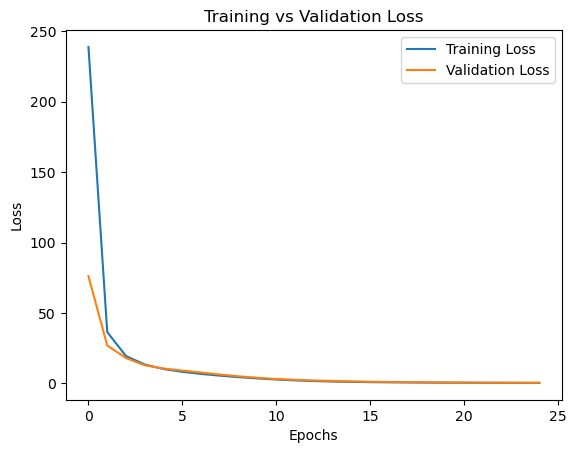

In [86]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [88]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4903 - mae: 0.4775
Test Loss: 0.4903245270252228
Test MAE: 0.47749724984169006


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


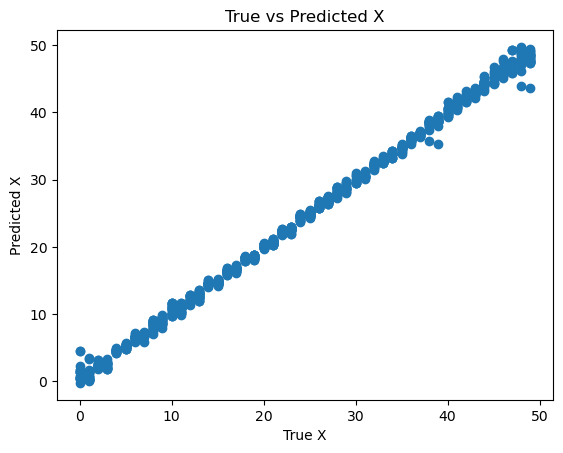

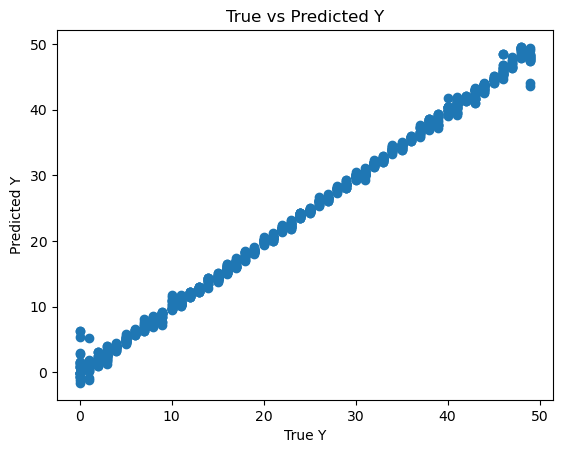

In [90]:
predictions = model.predict(X_test)

# X coordinate comparison
plt.figure()
plt.scatter(y_test[:, 0], predictions[:, 0])
plt.xlabel("True X")
plt.ylabel("Predicted X")
plt.title("True vs Predicted X")
plt.show()

# Y coordinate comparison
plt.figure()
plt.scatter(y_test[:, 1], predictions[:, 1])
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("True vs Predicted Y")
plt.show()


In [92]:

for i in range(5):
    print("True:", y_test[i])
    print("Predicted:", predictions[i])
    print("-----")


True: [15 30]
Predicted: [14.499202 30.08746 ]
-----
True: [16 19]
Predicted: [16.818382 18.458855]
-----
True: [21 23]
Predicted: [20.834604 22.519045]
-----
True: [15 30]
Predicted: [14.499202 30.08746 ]
-----
True: [47 43]
Predicted: [47.512733 42.286312]
-----


## Conclusion

The CNN model successfully learned to predict the (x, y) 
coordinates of a single bright pixel in a 50x50 grayscale image.

The decreasing training and validation loss indicate stable learning.
Scatter plots confirm strong alignment between predicted and true coordinates.

This demonstrates effective spatial localization using deep learning.
